# Neural Net testing

In [2]:
import numpy as np                                                              
import matplotlib.pyplot as plt
%matplotlib inline
from functools import reduce

import neuralNet as nn
import utils as u

## MNIST

In [3]:
from torchvision import datasets
train_dataset = datasets.MNIST('./data', train=True, download=True)
test_dataset = datasets.MNIST('./data', train=False, download=True)
X = train_dataset.data.numpy()
Y = train_dataset.targets.numpy()
tX = test_dataset.data.numpy()
tY = test_dataset.targets.numpy()


## Limit to only certain labels
#labels = range(1,11)
#X0, Y0 = X.copy(), Y.copy()
#tX0, tY0 = tX.copy(), tY.copy()
#
#inds = reduce(lambda x,y: x | y, [(Y == i) for i in labels])
#X, Y = X[inds], Y[inds]
#Y = np.array([labels.index(y) for y in Y])
#
#t_inds = reduce(lambda x,y: x | y, [(tY == i) for i in labels])
#tX, tY = tX[t_inds], tY[t_inds]
#tY = np.array([labels.index(y) for y in tY])


X = X.reshape([X.shape[0], -1]).astype(np.float64)
tX = tX.reshape([tX.shape[0], -1]).astype(np.float64)
Y = u.onehot(Y)
tY = u.onehot(tY)

Exception ignored in: <_io.FileIO name='/Users/akshayyeluri/anaconda3/envs/neural/lib/python3.6/site-packages/torchvision/_C.so' mode='rb' closefd=True>


In [4]:
model = nn.NeuralNet(sizes=[X.shape[1], 20, 10], eta=1e-4, loss='categorical', nonLin=['relu','softmax'], sf=0.05)
it, E_ins = model.learn(X, Y, maxIters=10, trackE_in=True, print_stuff=True)

Epoch 1: training loss = 0.2782151910554896
Epoch 2: training loss = 0.2088318604597145
Epoch 3: training loss = 0.20441773693519794
Epoch 4: training loss = 0.22177147827661056
Epoch 5: training loss = 0.2050200136876111
Epoch 6: training loss = 0.1712656790826667
Epoch 7: training loss = 0.18381224688396064
Epoch 8: training loss = 0.18710327203969176
Epoch 9: training loss = 0.22845741637859987
Epoch 10: training loss = 0.16134585938524715


Accuracy: 0.9447


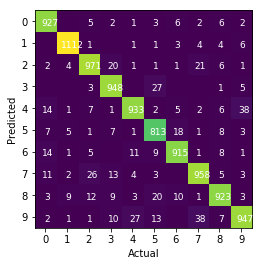

In [8]:
preds = model.predict(tX)
grid = u.confusions(preds, tY).astype(int)
u.plot_confusions(grid)
print(f'Accuracy: {1 - u.error_rate(preds, tY)}')

# Softmax Test

In [ ]:
f, line1 = u.genF(zero_one=True) # We want labels to be 0/1 not -1/1
X, Y = u.genData(f, 50)

In [ ]:
def nn_plot_helper(model, X, Y, E_ins, line1, transform = lambda w: [*w[0][1:], w[0][0]]):
    fig, ax = plt.subplots(2, 1, figsize=(8,8))
    u.plotE_ins(E_ins, axis=ax[0])
    u.plotLine(*line1, axis=ax[1], label='Target')
    u.plotLine(*transform(model.weights), color='g', \
                axis=ax[1], label='Hypothesis')
    inds = (Y == 1)                                
    ax[1].plot(X[inds, -2], X[inds, -1], 'b+')                   
    ax[1].plot(X[~inds, -2], X[~inds, -1], 'r_')
    ax[1].set_xlabel('X1'); ax[1].set_ylabel('X2')
    ax[1].set_xlim([-1, 1]); ax[1].set_ylim([-1, 1])
    ax[1].legend()
    return ax

In [ ]:
model = nn.NeuralNet(sizes=[3, 1], loss='log', nonLin='sigmoid')
it, E_ins = model.learn(X, Y, maxIters=500, trackE_in=True)
nn_plot_helper(model, X, Y, E_ins, line1);

In [ ]:
one_hot = lambda Y: np.hstack((Y[:, None], (1 - Y)[:, None]))
def transform(w):
    w_p = w[0][:, 0] - w[0][:, 1]
    return [*w_p[1:], w_p[0]]
    
model2 = nn.NeuralNet(sizes=[3, 2], loss='categorical', nonLin='softmax')
it, E_ins = model2.learn(X, one_hot(Y), maxIters=500, trackE_in=True)
nn_plot_helper(model2, X, Y, E_ins, line1, transform = transform);

## One variable function testing

In [ ]:
testFunc = lambda x: np.sin(2 * x)

inputs = np.linspace(-np.pi, np.pi, 200)
outputs = testFunc(inputs)

sizes = [1, 100, 100, 1]

## For cosine, need different nonlinearity
#model = nn.NeuralNet(sizes, nonLin='sigmoid')
model = nn.NeuralNet(sizes, nonLin='tanh')

it, E_ins = model.learn(inputs, outputs, maxIters=1000, trackE_in=True)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

u.plotE_ins(E_ins, axis=ax[0])
model.quickPlot(inputs, outputs, axis=ax[1])

fig.show()

In [ ]:
inputs = np.random.uniform(-np.pi, np.pi, 20)
outputs = testFunc(inputs)

outputs2 = np.array([model.calculate(i) for i in inputs])
outputs2 - outputs

## Multi-Variable Function Testing

In [ ]:
testFunc = lambda x, y: np.cos(x + y)

inputs = np.linspace(-np.pi / 2, np.pi / 2, 100)
inputs = np.vstack((inputs / 3, inputs * 2 / 3)).T
outputs = testFunc(inputs[:, 0], inputs[:, 1])

sizes = [2, 100, 100, 1]

model = nn.NeuralNet(sizes, nonLin='sigmoid')
#model = nn.NeuralNet(sizes)

it, E_ins = model.learn(inputs, outputs, maxIters=1000, trackE_in=True)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

u.plotE_ins(E_ins, axis=ax[0])

ax[1].plot(np.sum(inputs, axis=1), [model.calculate(i) for i in inputs], color='g', label='Net Outputs')
ax[1].plot(np.sum(inputs, axis=1), outputs, color='k', label='Real Outputs')
ax[1].set_xlabel('input')
ax[1].set_ylabel('output')
ax[1].legend()

fig.show()

In [ ]:
inputs = np.random.uniform(-np.pi, np.pi, 20)
inputs = np.vstack((inputs / 3, inputs * 2 / 3)).T
outputs = testFunc(inputs[:, 0], inputs[:, 1])

outputs2 = np.array([model.calculate(i) for i in inputs])
outputs2 - outputs

# XOR (doesn't work)

In [ ]:
testFunc = lambda x: np.sum(np.atleast_2d(x), axis=1) % 2

n_max = 1024
nDigs = len(bin(n_max)[2:])
inputs = np.array([[int(i) for i in list(bin(x)[2:].zfill(nDigs))] for x in range(n_max)])
outputs = testFunc(inputs)

sizes = [nDigs, 100, 1]

model = nn.NeuralNet(sizes, loss='log', nonLin='sigmoid')

it, E_ins = model.learn(inputs, outputs, maxIters=100, trackE_in=True)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

u.plotE_ins(E_ins, axis=ax)
#model.quickPlot(inputs, outputs, axis=ax[1])

fig.show()

outputs2 = np.round(np.array([model.calculate(i) for i in inputs]))